## Error

In [1]:
import numpy as np

In [26]:
# Mean Squared Error
def mean_squared_error(y: np.array, t: np.array):
    return 0.5 * np.sum((y - t) * (y - t))

# Cross Entropy Error
def cross_entropy_error(y: np.array, t: np.array):
    delta = 1e-7  # to avoid log0
    return -np.sum(t * np.log(y + delta))

In [27]:
# one-hot encoded target (2)
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]

# ex1) : probability of '2' is the highest, (result of softmax)
y1 = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]

# ex2) : probability of '7' is the highest
y2 = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0]

In [28]:
print('MSE of ex1 =', mean_squared_error(np.array(y1), np.array(t)))
print('MSE of ex2 =', mean_squared_error(np.array(y2), np.array(t)))

print()

print('CEE of ex1 =', cross_entropy_error(np.array(y1), np.array(t)))
print('CEE of ex2 =', cross_entropy_error(np.array(y2), np.array(t)))

MSE of ex1 = 0.09750000000000003
MSE of ex2 = 0.5975

CEE of ex1 = 0.510825457099338
CEE of ex2 = 2.302584092994546


## Mnist data

In [29]:
import sys, os 
sys.path.append(os.pardir)

from dataset.mnist import load_mnist

In [31]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, 
                                                  one_hot_label=True)

print('x_train.shape :', x_train.shape)
print('t_train.shape :', t_train.shape)

x_train.shape : (60000, 784)
t_train.shape : (60000, 10)


In [32]:
train_size = x_train.shape[0]
batch_size = 10
# 0~59999 에서 10개 random하게 추출
batch_mask = np.random.choice(train_size, batch_size)
x_batch = x_train[batch_mask]
t_batch = t_train[batch_mask]

print('batch_mask :', batch_mask)
print('x_batch.shape :', x_batch.shape)
print('t_batch.shape :', t_batch.shape)

batch_mask : [54517 53487 36876 28882  7125  2863 42455 32726 51830 12677]
x_batch.shape : (10, 784)
t_batch.shape : (10, 10)


## Cross entropy with minibatch

In [34]:
# mini-batch CEE
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    batch_size = y.shape[0]

    # 정답 레이블이 원-핫 인코딩이 아니라 '2'나 '7' 등의 숫자 레이블로 주어졌들 때
    # return -np.sum(np.log(y[np.arange(batch_size), t])) / batch_size
    
    return -np.sum(t * np.log(y)) / batch_size

## Differentitation

In [35]:
def numerical_diff(f, x):
    h = 1e-4  # 0.0001
    return (f(x+h) - f(x-h)) / (2*h)

In [36]:
def function_1(x):
    return 0.01*x**2 + 0.1*x

def tangent_line(f, x):
    d = numerical_diff(f, x)
    print(d)
    y = f(x) - d*x
    return lambda t: d*t + y

0.2999999999986347


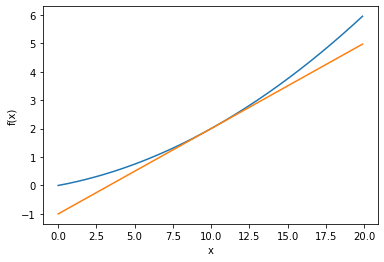

In [37]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt

x = np.arange(0.0, 20.0, 0.1)  # 0에서 20까지 0.1 간격의 배열 x를 만든다.
y = function_1(x)

tf = tangent_line(function_1, 10)
y2 = tf(x)

plt.xlabel('x'); plt.ylabel('f(x)')
plt.plot(x, y)
plt.plot(x, y2)
plt.show()

## Gradient

In [41]:
def _numerical_gradient_no_batch(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    for idx in range(x.size):
        tmp_val = x[idx]
        
        # f(x+h) 계산
        x[idx] = float(tmp_val) + h
        fxh1 = f(x)
        
        # f(x-h) 계산
        x[idx] = tmp_val - h 
        fxh2 = f(x) 
        
        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val
        
    return grad


def numerical_gradient(f, X):
    if X.ndim == 1:
        return _numerical_gradient_no_batch(f, X)
    else:
        grad = np.zeros_like(X)
        
        for idx, x in enumerate(X):
            grad[idx] = _numerical_gradient_no_batch(f, x)
        
        return grad

In [43]:
def function_2(x):
    if x.ndim == 1:
        return np.sum(x**2)
    else:
        return np.sum(x**2, axis=1)


def tangent_line(f, x):
    d = numerical_gradient(f, x)
    print(d)
    y = f(x) - d*x
    return lambda t: d*t + y

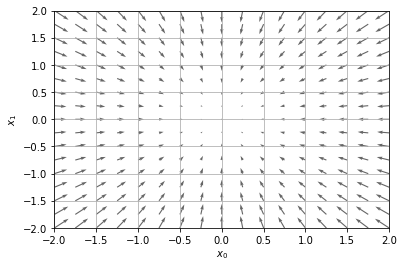

In [45]:
x0 = np.arange(-2, 2.5, 0.25)
x1 = np.arange(-2, 2.5, 0.25)
X, Y = np.meshgrid(x0, x1)

X = X.flatten()
Y = Y.flatten()

grad = numerical_gradient(function_2, np.array([X, Y]) )

plt.figure()
plt.quiver(X, Y, -grad[0], -grad[1], angles="xy",color="#666666")
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')
plt.grid()
plt.draw()
plt.show()

## Gradient descent

In [46]:
def gradient_descent(f, init_x, lr=0.01, step_num=100):
    x = init_x
    x_history = []

    for i in range(step_num):
        x_history.append( x.copy() )

        grad = numerical_gradient(f, x)
        x -= lr * grad

    return x, np.array(x_history)

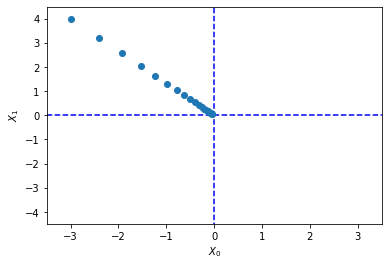

In [47]:
init_x = np.array([-3.0, 4.0])    

lr = 0.1
step_num = 20
x, x_history = gradient_descent(function_2, init_x, lr=lr, step_num=step_num)

plt.plot( [-5, 5], [0,0], '--b')
plt.plot( [0,0], [-5, 5], '--b')
plt.plot(x_history[:,0], x_history[:,1], 'o')

plt.xlim(-3.5, 3.5)
plt.ylim(-4.5, 4.5)
plt.xlabel("$X_0$")
plt.ylabel("$X_1$")
plt.show()

In [48]:
x

array([-0.03458765,  0.04611686])

## Gradient in neural network

In [49]:
from common.functions import softmax, cross_entropy_error
from common.gradient import numerical_gradient


class simpleNet:
    def __init__(self):
        self.W = np.random.randn(2, 3)  # 정규분포로 초기화
        
    def predict(self, x):
        return np.dot(x, self.W)
    
    def loss(self, x, t):
        z = self.predict(x)
        y = softmax(z)
        loss = cross_entropy_error(y, t)
        return loss

In [50]:
x = np.array([0.6, 0.9])
t = np.array([0, 0, 1])

net = simpleNet()

f = lambda w: net.loss(x, t)
dW = numerical_gradient(f, net.W)

print(net.W)
print(dW)

[[1.48463818 0.68443371 0.94128759]
 [0.06907994 0.94444029 1.99603451]]
[[ 0.09303646  0.12655703 -0.21959349]
 [ 0.13955469  0.18983555 -0.32939024]]


## Create model

In [52]:
from common.functions import *
from common.gradient import numerical_gradient


class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
        
    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        return y
    
    # x: 입력 데이터, t: 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
    
    # x: 입력 데이터, t: 정답 레이블
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        return grads
    
    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        da1 = np.dot(dy, W2.T)
        dz1 = sigmoid_grad(a1) * da1
        grads['W1'] = np.dot(x.T, dz1)
        grads['b1'] = np.sum(dz1, axis=0)

        return grads

In [54]:
net = TwoLayerNet(input_size=784, hidden_size=100, output_size=10)
net.params['W1'].shape

(784, 100)

In [56]:
x = np.random.rand(1, 784)  # 더미 입력 데이터(1장 분량)
t = np.random.rand(1, 10)  # 더미 정답 레이블(1장 분량)

grads = net.numerical_gradient(x, t)  # 기울기 계산
grads['W1'].shape

(784, 100)

## Train and test with MNIST

In [57]:
from IPython.core.pylabtools import figsize
from dataset.mnist import load_mnist


(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

# 하이퍼파라미터
iters_num = 10000 # 반복 횟수
train_size = x_train.shape[0]
batch_size = 100  # 미니배치 크기
learning_rate = 0.1

# 저장할 리스트 정의
train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1 에폭당 반복 수
iter_per_epoch = int(train_size / batch_size)

In [58]:
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

for step in range(iters_num):
    # Mini-Batch
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 기울기 계산
    grad = network.gradient(x_batch, t_batch)
    
    # 매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
        
    # 학습 과정 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    # 1 epoch 당 정확도 계산
    if (step+1) % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("Step: {:04d}, Train Acc: {:.5f}, Test Acc: {:.5f}".format(step+1, train_acc, test_acc))

Step: 0600, Train Acc: 0.78203, Test Acc: 0.78760
Step: 1200, Train Acc: 0.87813, Test Acc: 0.88340
Step: 1800, Train Acc: 0.89782, Test Acc: 0.90230
Step: 2400, Train Acc: 0.90793, Test Acc: 0.91140
Step: 3000, Train Acc: 0.91503, Test Acc: 0.91810
Step: 3600, Train Acc: 0.91915, Test Acc: 0.92270
Step: 4200, Train Acc: 0.92372, Test Acc: 0.92690
Step: 4800, Train Acc: 0.92690, Test Acc: 0.92920
Step: 5400, Train Acc: 0.93058, Test Acc: 0.93240
Step: 6000, Train Acc: 0.93398, Test Acc: 0.93500
Step: 6600, Train Acc: 0.93710, Test Acc: 0.93940
Step: 7200, Train Acc: 0.93800, Test Acc: 0.94000
Step: 7800, Train Acc: 0.94045, Test Acc: 0.94150
Step: 8400, Train Acc: 0.94320, Test Acc: 0.94260
Step: 9000, Train Acc: 0.94512, Test Acc: 0.94360
Step: 9600, Train Acc: 0.94605, Test Acc: 0.94500


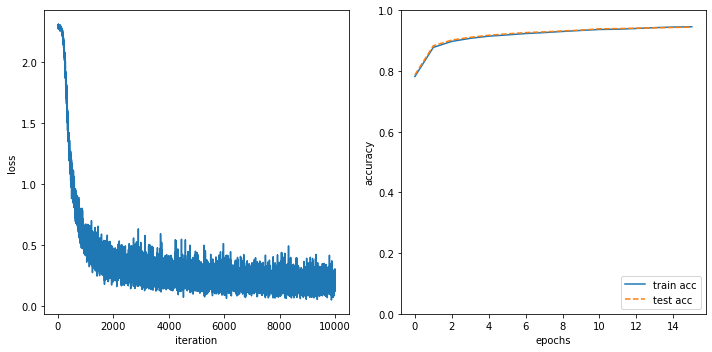

In [59]:
# 그래프 그리기
figsize(10, 5)
markers = {'train': 'o', 'test': 's'}
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

x_loss = np.arange(len(train_loss_list))
ax1.plot(x_loss, train_loss_list)
ax1.set_xlabel("iteration")
ax1.set_ylabel("loss")

x_acc = np.arange(len(train_acc_list))
ax2.plot(x_acc, train_acc_list, label='train acc')
ax2.plot(x_acc, test_acc_list, label='test acc', linestyle='--')
ax2.set_xlabel("epochs")
ax2.set_ylabel("accuracy")
ax2.set_ylim(0, 1.0)
ax2.legend(loc='lower right')
plt.tight_layout()
plt.show()